Imports and Constants

In [31]:
from abc import ABC

import time

import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
layers = {'content_layers': content_layers, 'style_layers': style_layers}

Image

In [32]:
def load_image(image_path):
    max_dim = 512

    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]

    return image


def plot_images(content_image, style_image, new_image=None):
    def show_image(image, title=None):
        if len(image.shape) > 3:
            image = tf.squeeze(image, axis=0)

        plt.imshow(image)

        if title:
            plt.title(title)

    cols = 2 if new_image is None else 3

    plt.figure(figsize=(15, 15))

    plt.subplot(1, cols, 1)
    show_image(content_image, 'Content Image')

    plt.subplot(1, cols, 2)
    show_image(style_image, 'Style Image')

    if cols == 3:
        plt.subplot(1, cols, 3)
        show_image(new_image, 'New Image')

    plt.show()


def clip_image(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def convert_tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)

    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]

    return PIL.Image.fromarray(tensor)


Model

In [33]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    return tf.keras.Model([vgg.input], outputs)


def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    return result / num_locations


class StyleContentModel(tf.keras.models.Model, ABC):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()

        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs, *args, **kwargs):
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs * 255.0)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


Transfer

In [34]:
def transfer_style(image, epochs, steps_per_epoch, optimizer, layers, inputs, weights):
    @tf.function()
    def train_step():
        def compute_style_content_loss():
            style_outputs = outputs['style']
            content_outputs = outputs['content']

            content_image = inputs['content_image']
            style_image = inputs['style_image']

            style_targets = extractor(style_image)['style']
            content_targets = extractor(content_image)['content']

            style_weight = weights['style_weight']
            content_weight = weights['content_weight']

            style_loss = tf.add_n(
                [tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
            style_loss *= style_weight / len(style_layers)

            content_loss = tf.add_n(
                [tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in
                 content_outputs.keys()])
            content_loss *= content_weight / len(content_layers)

            return style_loss + content_loss

        total_variation_weight = weights['total_variation_weight']

        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = compute_style_content_loss()
            loss += total_variation_weight * tf.image.total_variation(image)

        grad = tape.gradient(loss, image)
        optimizer.apply_gradients([(grad, image)])

        image.assign(clip_image(image))

    style_layers = layers['style_layers']
    content_layers = layers['content_layers']

    extractor = StyleContentModel(style_layers, content_layers)

    start = time.time()

    for epoch in range(epochs):
        start_epoch = time.time()

        print("Training epoch: {} out of {}".format(epoch + 1, epochs))

        for step in range(steps_per_epoch):
            if (step + 1) % 50 == 0:
                print("Step: {}".format(step + 1))

            train_step()

        end = time.time()

        print("Epoch time: {:.1f}s".format(end - start_epoch))
        print("Total time: {:.1f}s".format(end - start))
        print()


Input Images

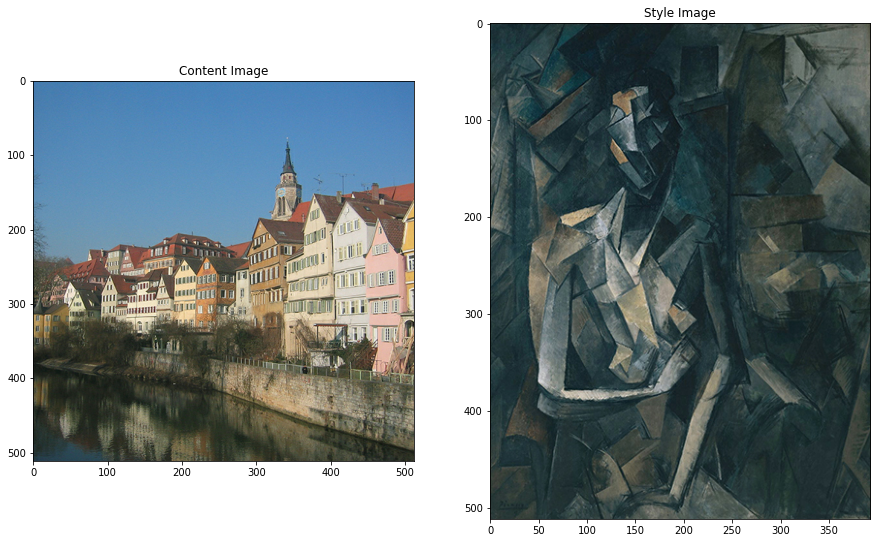

In [35]:
content_name = 'tubingen'
style_name = 'Picasso'

image_path = '../content/data/'
content_path = image_path + 'content/' + content_name + '.jpg'
style_path = image_path + 'style/' + style_name + '.jpg'
output_path = image_path + 'output/' + content_name + style_name + '.jpg'

content_image = load_image(content_path)
style_image = load_image(style_path)
inputs = {'content_image': content_image, 'style_image': style_image}

plot_images(content_image, style_image)

Hyperparameters

In [36]:
epochs = 5
steps_per_epoch = 10

optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30
weights = dict(style_weight=style_weight, content_weight=content_weight, total_variation_weight=total_variation_weight)

Style Transfer


Training epoch: 1 out of 5
Epoch time: 2.6s
Total time: 2.6s

Training epoch: 2 out of 5
Epoch time: 1.4s
Total time: 4.1s

Training epoch: 3 out of 5
Epoch time: 1.4s
Total time: 5.5s

Training epoch: 4 out of 5
Epoch time: 1.4s
Total time: 6.9s

Training epoch: 5 out of 5
Epoch time: 1.4s
Total time: 8.3s



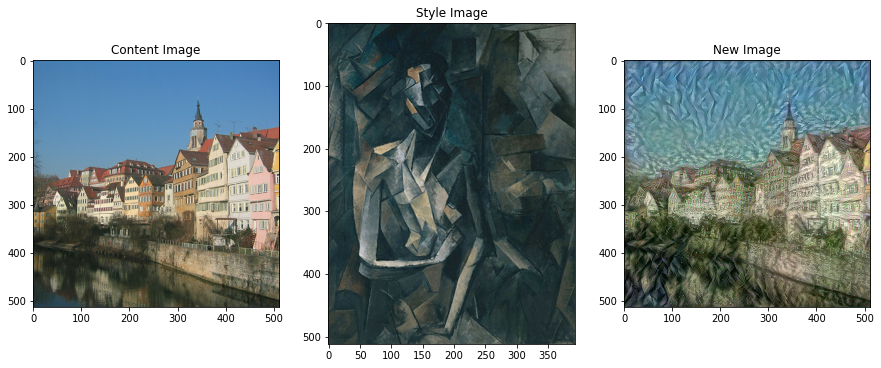

In [37]:
image = tf.Variable(content_image)
transfer_style(image, epochs, steps_per_epoch, optimizer, layers, inputs, weights)

convert_tensor_to_image(image).save(output_path)

new_image = load_image(output_path)
plot_images(content_image, style_image, new_image)